<a href="https://colab.research.google.com/github/karencfisher/hotel-reviews/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA

This notebook also calculates an average score (across the areas of the guest scores on various attributes such as cleanliness or service), and bucketize those scores into a binary sentiment (good = 1, bad = 0). The large data set is then sampled to a balanced sample of 5% of 444,233 reviews), and store that sample as a CSV.

In [1]:
from tensorflow.python.keras.utils.version_utils import TensorBoardVersionSelector
import pandas as pd
import numpy as np
import re
import datetime
import nltk
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_reviews = pd.read_csv('/content/drive/MyDrive/hotel_reviews/reviews.csv')
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,Date,ReviewID
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,"April 20, 2012",UR128207934
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,"April 11, 2012",UR127662460
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,"April 11, 2012",UR127648467
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,"April 6, 2012",UR127365749
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...","April 2, 2012",UR127143142


In [23]:
df_reviews.shape

(444233, 10)

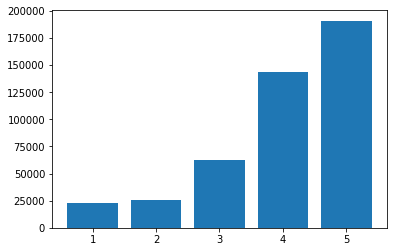

In [4]:
plt.bar([1, 2, 3, 4, 5], df_reviews['Overall'].value_counts().sort_index());

### Baseline using Overall column as targets. 

Accuracy just randomly guessing the class for an example

In [5]:
n_classes = df_reviews['Overall'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((n_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')

Baseline accuracy:  31.42%


In [6]:
# Drop date and reviewID columns
df_reviews.drop(columns=['Date', 'ReviewID'], inplace=True)

# Add column for average score (averaging ratings for each review)
cols = df_reviews.columns[:7]
df_reviews['average_score'] = df_reviews[cols].mean(axis=1)


In [7]:
df_reviews.head()

,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Title,Content,average_score
0,5,5,5,5,5,5,5,“Super stay.”,This the second time we have stayed and this t...,5.000000
1,5,5,4,4,5,5,4,“Permanent improvements in various aereas to b...,My experience as a rare but regular guest with...,4.571429
2,5,5,5,4,5,4,4,“span pacific orchard”,Great hotel in good location for night life & ...,4.571429
3,5,5,5,4,5,5,4,“Great value for money in heart of the shoppin...,The Pan Pac Orchard is in a great location rig...,4.714286
4,5,4,5,5,4,5,4,“Pan Pacific Orchard”,"Stayed for 3 nights. Hotel is clean, tasty foo...",4.571429


### Distrubution of average scores

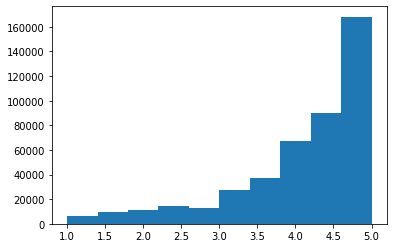

In [8]:
plt.hist(df_reviews['average_score'], bins=10);

### Approximate baseline accuracy

Guessing randomly of 10 classes accross distribution of average_scores

In [9]:
counts = np.histogram(df_reviews['average_score'], bins=10)[0]
n = df_reviews.shape[0]
baseline = np.sum((counts / n) ** 2)
print(f'Aporiximate baseline accuracy: {baseline * 100: .2f}%')

Aporiximate baseline accuracy:  22.13%


### Sample titles and descriptions by average score

In [10]:
import textwrap

wrapper = textwrap.TextWrapper(width=140)
for i in range(1, 6):
  print(f'Average Score: {i}')
  cond = df_reviews['average_score'].astype(int) == i
  df_sample = df_reviews[cond].sample(10).sort_values(by='average_score')
  for row in range(len(df_sample)):
    print(df_sample.iloc[row]['Title'], '\n', f'Score = {df_sample.iloc[row]["average_score"]: .2f}')
    text = wrapper.wrap(df_sample.iloc[row]['Content'])
    for w in text:
      print(w)
    print('\n')
  print('*************\n')

Average Score: 1
“Don't stay” 
 Score =  1.00
We stayed here for only 2 nights and had to switch our rooms 2 times. This "hotel" is not very clean. It had very large "dust bunnies",
bathroom lighing is horrible, bathroom mirror was so marked up you couldn't see in it. No wash clothes unless you went down to the front
desk and ask for thim. Towels were very ruff and many holes in them. Very loud air conditioners (in the windows). No central air. Elevator
is extremely small!! Please do not stay here if you are handicapped. Location was a little out the way, it would have been OK if the hotel
had been clean. We travel to NYC about 2 times a year and I would not stay here again.


“PLEASE, PLEASE, PLEASE DON'T STAY AT THIS HOTEL...Don't be lured by the cheap price!” 
 Score =  1.14
This is the first review I have ever written, and I'm not the sort of person to complain usually but I do feel that anyone who is
considering staying at this hotel deserves an honest and accurate review of this 

### Bucketize reviews into two sentiments, Good vs. Bad

Threshold = average score 3.5

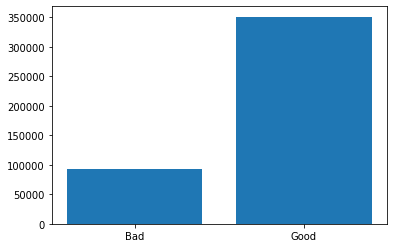

In [11]:
df_reviews['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_reviews['sentiment'].value_counts().sort_index());

### Calculate a baseline accuracy

Randomly guessing 0 or 1 for each example

In [12]:
num_classes = df_reviews['sentiment'].value_counts().values
n = df_reviews.shape[0]
baseline = np.sum((num_classes / n) ** 2)
print(f'Baseline accuracy: {baseline * 100: .2f}%')


Baseline accuracy:  66.89%


In [13]:
nltk.download(['names', 'stopwords'])
stopwords = nltk.corpus.stopwords.words("english")

def cleanText(document):
  text = re.sub('[^a-zA-Z0-9 ]', '', document)
  tokens = text.lower().split()
  tokens = [w for w in tokens if w not in stopwords]
  return " ".join(tokens)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
df_reviews['Title'] = df_reviews['Title'].apply(lambda x: x.replace('“','').replace('”',''))
df_reviews['Content'] = df_reviews['Title'] + ' ' + df_reviews['Content']
df_reviews.drop(columns=['Title'], inplace = True)
df_reviews['Content'] = df_reviews['Content'].apply(cleanText)
df_reviews.sample(10)


,Cleanliness,Location,Overall,Rooms,Service,Sleep Quality,Value,Content,average_score,sentiment
126073,5,5,5,5,5,5,5,perfect oasis 23 hour flight spent three night...,5.000000,1
376244,4,4,2,2,2,2,1,key card snafu arrived one nite stay prior cru...,2.428571,0
154593,5,4,4,4,5,5,5,worth price spent 2 nights comfort suitesnow c...,4.571429,1
85163,5,5,5,5,5,4,5,superb hotel stayed ottoman 4 nights cant beli...,4.857143,1
420398,5,4,5,5,5,5,5,excellent vacation cant wait return next year ...,4.857143,1
82175,5,4,5,4,5,4,5,great stay great service researched many hotel...,4.571429,1
248471,5,5,5,5,5,5,5,fantastic apartments friend stayed crosti apar...,5.000000,1
136851,3,1,3,3,3,4,3,way stayed nights paris denfertrochereau stati...,2.857143,0
311074,1,3,1,1,1,2,1,horrible place stay take toilet paper first th...,1.428571,0
105449,5,5,5,4,5,5,4,great family vacation boardwalk puts rigt midd...,4.714286,1


### Make a CSV of a balanced sample

This way the baseline accuracy will be 50%

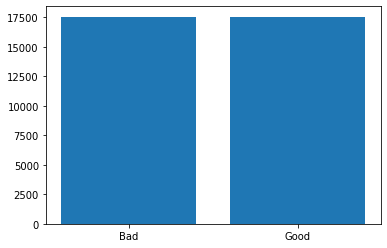

In [22]:
df1 = df_reviews[df_reviews['sentiment'] == 1].sample(frac=0.05)
rows = df1.shape[0]
df0 = df_reviews[df_reviews['sentiment'] == 0].sample(rows)
df_sampled = pd.concat([df0, df1], axis = 0)

df_sampled['sentiment'] = df_reviews['average_score'].apply(lambda x: 1 if x >= 3.5 else 0)
plt.bar(['Bad', 'Good'], df_sampled['sentiment'].value_counts().sort_index());

data_path = '/content/drive/MyDrive/hotel_reviews/reviews_sample.csv'
df_sampled.to_csv(data_path)
